<a href="https://colab.research.google.com/github/8talha/iH3Q2eGehReqiWD2/blob/main/Happy_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install eli5

In [34]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.cluster import KMeans 
import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
csv_path='/content/drive/MyDrive/dataset/happy/ACME-HappinessSurvey2020.csv'

In [36]:
# Loading train and test data
df = pd.read_csv(csv_path)

In [37]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [38]:
df['split'] = np.random.randn(df.shape[0], 1)

In [39]:
msk = np.random.rand(len(df)) <= 0.7

train = df[msk]
test = df[~msk]

In [40]:
test.shape

(39, 8)

In [41]:
train.shape

(87, 8)

In [42]:
train.head()

,Y,X1,X2,X3,X4,X5,X6,split
1,0,3,2,3,5,4,3,0.498337
2,1,5,3,3,3,3,5,-0.596488
3,0,5,4,3,3,3,5,-0.272488
4,0,5,4,3,3,3,5,1.022239
6,0,3,1,2,2,1,3,-0.556614


In [43]:
# Checking for null values
li = train.isnull().sum().values
li 

array([0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
train["Y"].value_counts()

1    46
0    41
Name: Y, dtype: int64

In [45]:
# happy customers have Y==0, unhappy custormers have Y==1
df1 = pd.DataFrame(train.Y.value_counts())
df1['Percentage'] = 100*df1['Y']/df.shape[0]
df1

,Y,Percentage
1,46,36.507937
0,41,32.539683


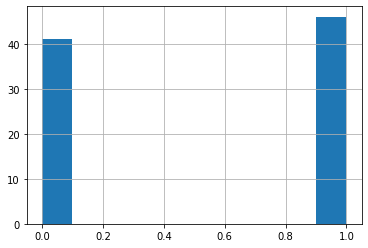

In [46]:
# Visualizing proportion of target values using a histogram
train['Y'].hist();

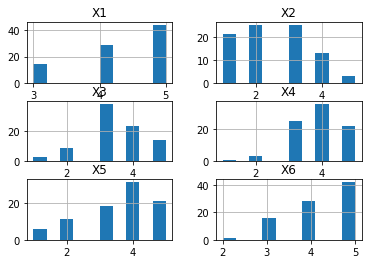

In [58]:
# num_var4 is the number of products. Let's plot the distribution:
train[['X1','X2','X3','X4','X5','X6']].hist()
#plt.xlabel('Questions')
#plt.ylabel('Number of customers in train')
#plt.title('Graphs')
plt.show()

### Data Preprocessing
Preprocessing involves the following steps:
- Removing constant columns ( columns whose standard deviation is 0)
- From then, remove duplicated columns 
- split the data into training data, training label and test data
- Use unsupervised learning (K-means clustering) to cluster the data based on smilarity between features and add them to the train and test data 

In [106]:
def preprocess(train,test):
    
        
    """clean and split data
    Args:
        train: Training data.
        test: Testing data
    Returns:
        X: Features for modeling.
        Y: Labels for model.
        test: test features for modeling.
        test_id: test id's
    """

    
    # remove constant columns (std = 0)
    remove = []
    
    for col in train.columns:
        
        if train[col].std() == 0:
            remove.append(col)

    train.drop(remove, axis=1, inplace=True)
    test.drop(remove, axis=1, inplace=True)

    # remove duplicated columns
    remove = []
    cols = df.columns
    for i in range(len(cols)-1):
        v = df[cols[i]].values
        for j in range(i+1,len(cols)):
            if np.array_equal(v,df[cols[j]].values):
                remove.append(cols[j])

    train.drop(remove, axis=1, inplace=True)
    test.drop(remove, axis=1, inplace=True)
    
# split data into train and test
    test_id = test.Y.values
    
    test_out = test.drop(["Y","split"],axis=1)
    
    X = train.drop(["Y","split"],axis=1)
    y = train.Y.values
    return X, y, test_out , test_id


In [107]:
X, y, test_out , test_id = preprocess(train,test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [112]:
X.shape

(87, 6)

In [113]:
y.shape

(87,)

In [114]:
test_out.shape

(39, 6)

In [115]:
test_id.shape

(39,)

In [116]:
#  Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X) 
pred_test = kmeans_1.fit_predict(test_out) 

In [119]:
test['preditions'] = pred_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
X['preditions'] = predictions

Initial model



In [121]:
# making test - valid sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [123]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'num_leaves' : 76,
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'auc',
    'max_depth':5
}
# making lgbm datasets for train and valid
d_train = lgbm.Dataset(X_train, y_train)
d_valid = lgbm.Dataset(X_test, y_test)
    
    # training with early stop
bst = lgbm.train(params, d_train, 5000,  valid_sets=[d_valid], verbose_eval=50, early_stopping_rounds=100) 
    
    # making prediciton for one column

print('Fininshed Training')

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.638889
[100]	valid_0's auc: 0.638889
Early stopping, best iteration is:
[34]	valid_0's auc: 0.805556
Fininshed Training


Initially, I splitted the data into training and validation data to evaluate how well metric performed
- Then, I used lightgbm as supervised learning model
- Initial model consists of mainly default parameters, the main thing I modified was the metric to "auc" and also precised the objective which is binary classification.early stopping was used to monitor training.
- Best validation auc for the initial model gave a value of 0.699646
- Then I tuned a few parameters, The parameters tuned are as follows:
num_leaves = 76,
bagging_fraction= 0.8,
bagging_freq=1,
boosting_type=gbdt,
max_depth=5
- Best validation auc for the tuned model gave a value of 0.80556



In [124]:
# Using permutation importance to know the most relevant features for prediction
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

perm = PermutationImportance(my_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1556 ± 0.1089,X1
0.1111 ± 0.1988,X2
0.0222 ± 0.2177,X6
0 ± 0.0000,preditions
0 ± 0.0000,X3
-0.0667 ± 0.1089,X5
-0.1333 ± 0.0889,X4


In [125]:
pred =  bst.predict(test)

### Conclusion

The project is about predicting whether the customers of a business will be happy or not with the business’s product.To illustrate that, we used the dataset Santader released on kaggle.
- Some data visualizations was done and showed for example that unhappy customers used less products.
- Some data processing was done and clustering was also implemented to group data with similar features.
- Machine learning was then used to predict customer’s satisfaction where an auc of 0.841805 was obtained.
- The top 20 features relevant to prediction was then displayed.


Initially the default parameters for lightgbm was used to train the data,for which we get accuracy round 0.69956
The tuned lightgbm model, gave an accuracy of 0.80556 and a p

The main challenge in this project I faced was tuning parameters for lighgbm. 
I would like to thanks this blog for helping in training these paameters
URL: https://medium.com/@ericnguifo/machine-learning-can-predict-whether-a-customer-is-happy-or-not-7037f8761b6d